# LES tendencies

1. This has to be run on casper
2. I would add a 5 day buffer on `les_time_length`
3. I've removed the coriolis contribution, so the LES needs `f≠0`
4. I have not checked the 12H offset in time

`/glade/p/cgd/oce/people/dwhitt/TPOS/tpos_LES_runs_setup_scripts/tpos-DIABLO/diablo_2.0/tpos_config_files`

In [2]:
import cf_xarray
import dask
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xgcm

import dcpy
import pump
import pump.les
import pump.model
from pump.les import interleave_time, interpolate, write_to_txt

dask.config.set(**{'array.slicing.split_large_chunks': False})  # silence some warnings

Sets up a dask cluster; only run once

In [3]:
import ncar_jobqueue

cluster = ncar_jobqueue.NCARCluster(account="ncgd0011")
cluster.scale(12)
import distributed

client = distributed.Client(cluster)
client

<Client: 'tcp://10.12.205.32:44115' processes=0 threads=0, memory=0 B>

Things you could change; if changing, rerun all cells below (Use the `Run` menu above)

In [4]:
outdir = "/glade/work/dcherian/pump/les_forcing/mitgcm_test/"  # output directory for txt files

whichz = "216"  # or "288"  # which z grid h5 file to use

leslon = -140  # it will find the nearest
leslat = 0  # will find the nearest

# start date for les; noon is a good time (it is before sunrise)
sim_time = pd.Timestamp("2008-10-24 12:00:00")

# ADD a 5 day buffer here (:] all kinds of bugs at the beginning and end)
les_time_length = 30  # (days); length of time for forcing/pushing files

LES things that you need not change; Grid is chosen by `whichz` in the above cell

In [5]:
# Should not need to change anything below this
griddir = "/glade/p/cgd/oce/people/dwhitt/TPOS/tpos_LES_runs_setup_scripts/tpos-DIABLO/diablo_2.0/pre_process/"
renamer = {
    "u": "U",
    "v": "W",
    "temp": "T",
    # "salt": "S"
}
offset = xr.Dataset({"U": 0.4, "T": 25, "S": 35.25, "W": 0})
t0 = (sim_time).to_numpy()

grid = h5py.File(
    f"{griddir}/gridtpos{whichz}.h5", mode="r"
)
zles = grid["grids"]["y"][:]
grid.close()
zles = 0.5 * (zles[1:-1] + zles[2:])
newz = xr.DataArray(
    zles - zles.max() - 0.25, dims="z", name="z"  # this is what dan does
)
newz  # prints out the grid

<xarray.DataArray 'z' (z: 216)>
array([-107.75, -107.25, -106.75, -106.25, -105.75, -105.25, -104.75,
       -104.25, -103.75, -103.25, -102.75, -102.25, -101.75, -101.25,
       -100.75, -100.25,  -99.75,  -99.25,  -98.75,  -98.25,  -97.75,
        -97.25,  -96.75,  -96.25,  -95.75,  -95.25,  -94.75,  -94.25,
        -93.75,  -93.25,  -92.75,  -92.25,  -91.75,  -91.25,  -90.75,
        -90.25,  -89.75,  -89.25,  -88.75,  -88.25,  -87.75,  -87.25,
        -86.75,  -86.25,  -85.75,  -85.25,  -84.75,  -84.25,  -83.75,
        -83.25,  -82.75,  -82.25,  -81.75,  -81.25,  -80.75,  -80.25,
        -79.75,  -79.25,  -78.75,  -78.25,  -77.75,  -77.25,  -76.75,
        -76.25,  -75.75,  -75.25,  -74.75,  -74.25,  -73.75,  -73.25,
        -72.75,  -72.25,  -71.75,  -71.25,  -70.75,  -70.25,  -69.75,
        -69.25,  -68.75,  -68.25,  -67.75,  -67.25,  -66.75,  -66.25,
        -65.75,  -65.25,  -64.75,  -64.25,  -63.75,  -63.25,  -62.75,
        -62.25,  -61.75,  -61.25,  -60.75,  -60.25,  -59.75,  -59.25,
        -58.75,  -58.25,  -57.75,  -57.25,  -56.75,  -56.25,  -55.75,
        -55.25,  -54.75,  -54.25,  -53.75,  -53.25,  -52.75,  -52.25,
        -51.75,  -51.25,  -50.75,  -50.25,  -49.75,  -49.25,  -48.75,
        -48.25,  -47.75,  -47.25,  -46.75,  -46.25,  -45.75,  -45.25,
        -44.75,  -44.25,  -43.75,  -43.25,  -42.75,  -42.25,  -41.75,
        -41.25,  -40.75,  -40.25,  -39.75,  -39.25,  -38.75,  -38.25,
        -37.75,  -37.25,  -36.75,  -36.25,  -35.75,  -35.25,  -34.75,
        -34.25,  -33.75,  -33.25,  -32.75,  -32.25,  -31.75,  -31.25,
        -30.75,  -30.25,  -29.75,  -29.25,  -28.75,  -28.25,  -27.75,
        -27.25,  -26.75,  -26.25,  -25.75,  -25.25,  -24.75,  -24.25,
        -23.75,  -23.25,  -22.75,  -22.25,  -21.75,  -21.25,  -20.75,
        -20.25,  -19.75,  -19.25,  -18.75,  -18.25,  -17.75,  -17.25,
        -16.75,  -16.25,  -15.75,  -15.25,  -14.75,  -14.25,  -13.75,
        -13.25,  -12.75,  -12.25,  -11.75,  -11.25,  -10.75,  -10.25,
         -9.75,   -9.25,   -8.75,   -8.25,   -7.75,   -7.25,   -6.75,
         -6.25,   -5.75,   -5.25,   -4.75,   -4.25,   -3.75,   -3.25,
         -2.75,   -2.25,   -1.75,   -1.25,   -0.75,   -0.25])
Dimensions without coordinates: z

## MITgcm

The daily avg output was subset in MATLAB syntax : `41:end-40, 41:end-40, 1:nz`

In [6]:
# don't change anything here
output_start_time = pd.Timestamp("1999-01-01")  # don't change
firstfilenum = (
    (sim_time - pd.Timedelta("1D") - output_start_time)  # add one day offset to aoid bugs
    .to_numpy()
    .astype("timedelta64[D]")
    .astype("int")
)
lastfilenum = firstfilenum + les_time_length

def subsetter(ds, time=True):
    """ This function subsets to the chosen location and time"""
    sub = ds.cf.sel(X=leslon, Y=leslat, method="nearest")
    if time:
        sub = sub.cf.sel(
            time=slice(sim_time, sim_time + pd.Timedelta(f"{les_time_length}D"))
        ).isel(time=slice(-1))

    if "z_rho" in sub.coords:
        sub["z_rho"] = sub.z_rho.cf.mean("time")
        sub = sub.swap_dims({"s_rho": "z_rho"})
        sub["z_rho"].attrs["axis"] = "Z"
    return sub

### Read all ocean model output

In [10]:
gcmdir = "/glade/campaign/cgd/oce/people/bachman/TPOS_MITgcm_fix3/"  # MITgcm output directory


def gen_file_list(suffix):
    files = [
        f"{gcmdir}/File_{num}_{suffix}.nc"
        for num in range(firstfilenum - 1, lastfilenum + 1)
    ]

    return files


coords = pump.model.read_mitgcm_coords(gcmdir)
grid = xgcm.Grid(
    coords, periodic=False, boundary={"X": "extend", "Y": "extend", "Z": "extend"}
)

# ssh data
ssh = (
    xr.open_mfdataset(
        gen_file_list(suffix="etan"),
        chunks={"latitude": 120, "longitude": 500},
        combine="by_coords",
        parallel=True,
    )
    .rename({"latitude": "YC", "longitude": "XC"})
    .update(coords.coords)
)

# momentum budget terms
budgets = xr.open_mfdataset(
    gen_file_list(suffix="ub") + gen_file_list(suffix="vb"),
    chunks={"latitude": 120, "longitude": 500},
    combine="by_coords",
    parallel=True,
)
budgets = pump.model.rename_mitgcm_budget_terms(budgets, coords).update(
    coords.coords
)

# surface data
surf = (
    xr.open_mfdataset(
        gen_file_list(suffix="surf"),
        chunks={"latitude": 120, "longitude": 500},
        combine="by_coords",
        parallel=True,
    )
    .rename({"latitude": "YC", "longitude": "XC"})
    .update(coords.coords)
)
surf["oceQsw"] = surf.oceQsw.fillna(0)
surf["taux"] = 1035 * 2.5 * budgets["Um_Ext"].isel(RC=0)
surf["tauy"] = 1035 * 2.5 * budgets["Vm_Ext"].isel(RC=0)

# heat budget terms
hb = xr.open_mfdataset(
    gen_file_list(suffix="hb"),
    chunks={"latitude": 120, "longitude": 500},
    combine="by_coords",
    parallel=True,
)
hb_ren = pump.model.rename_mitgcm_budget_terms(hb, coords).update(coords.coords)

# state variables
state = xr.open_mfdataset(
    gen_file_list(suffix="buoy"),
    chunks={"latitude": 120, "longitude": 500},
    combine="by_coords",
    parallel=True,
).rename({"latitude": "YC", "longitude": "XC", "depth": "RC"})
state["u"] = state.u.rename({"XC": "XG"})
state["v"] = state.v.rename({"YC": "YG"})
state = state.update(coords.coords)


# grid metrics
metrics = (
    pump.model.read_metrics(gcmdir)
    .compute()
    .isel(longitude=slice(40, -40), latitude=slice(40, -40), depth=slice(136))
    .chunk({"latitude": 120, "longitude": 500})
    .drop(["latitude", "longitude", "depth"])
    .rename({"depth_left": "RF", "depth": "RC", "latitude": "YC", "longitude": "XC"})
    .set_coords("RF")
    .isel(RF=slice(136))
)
metrics["rAw"] = metrics.rAw.rename({"XC": "XG"})
metrics["rAs"] = metrics.rAs.rename({"YC": "YG"})
metrics["hFacW"] = metrics.hFacW.rename({"XC": "XG"})
metrics["hFacS"] = metrics.hFacS.rename({"YC": "YG"})
metrics["DXG"] = metrics.DXG.rename({"YC": "YG"})
metrics["DYG"] = metrics.DYG.rename({"XC": "XG"})
metrics = metrics.update(coords.coords)

# penetrative shortwave radiation profile
swprofile = (
    xr.DataArray(
        pump.model.mitgcm_sw_prof(metrics.RF[:-1].values)
        - pump.model.mitgcm_sw_prof(metrics.RF[1:].values),
        dims=["RC"],
        attrs={"long_name": "SW radiation deposited in cell"},
    )
    .assign_coords(RC=coords.coords["RC"][:-1])
    .reindex(RC=coords.coords["RC"])
)

Offset in time (I have not checked this).

In [11]:
ssh["time"] = ssh.time + pd.Timedelta("12H")
budgets["time"] = budgets.time + pd.Timedelta("12H")
state["time"] = state.time + pd.Timedelta("12h")
hb_ren["time"] = hb_ren.time + pd.Timedelta("12h")
surf["time"] = surf.time + pd.Timedelta("12h")

Make sure that everything is on the same grid; just a check.

In [13]:
xr.align(budgets, ssh, state, hb_ren, metrics,  surf, join="exact");

### Plot ocean state to see what we get

I didn't finish this; but this is the directory you can look at for hourly station output

In [14]:
q, r = divmod(firstfilenum, 250)
folder = f"{250*q + 1}-{250*(q+1)}"

print(f"{gcmdir}/Day_{folder}/")
#station = pump.model.model.read_stations_20(
#    dayglobstr=folder, dirname=gcmdir, globstr="*_-140*.nc"
#)

/glade/campaign/cgd/oce/people/bachman/TPOS_MITgcm_fix3//Day_3501-3750/


### Estimate flux divergences

In [15]:
# constants taken from diagnostics.log (I think)
global_area = 2.196468634481708e13
rhoConst = 1035
Cp = 3994
f0 = 2 * (2 * np.pi / 86400) * np.sin(leslat * np.pi / 180)

# This is WRONG! Because we have subset the output this won't recover the MITgcm correction exactly
# seems to be particularly bad at t=0
surf_mass = (hb_ren.WTHMASS * metrics.RAC).isel(RC=0)
TsurfCor = surf_mass.sum(["XC", "YC"]) / global_area


def expand_depth(ds):
    if "RC" not in ds:
        ds["RC"] = coords.RC.isel(RC=0).data
    return ds.expand_dims("RC").reindex(RC=coords.RC, fill_value=0)


budgets["surf_corr_tend"] = -1 * (
    (TsurfCor - hb_ren.WTHMASS.isel(RC=0))
    / metrics.dRF.isel(RC=0)
    / metrics.hFacC.isel(RC=0)
).pipe(expand_depth)
budgets["TOTTTEND"] = hb_ren.TOTTTEND


budgets["ADV_TH"] = (
    -1
    * (
        grid.diff(hb_ren.ADVx_TH, "X")
        + grid.diff(hb_ren.ADVy_TH, "Y")
        - grid.diff(
            hb_ren.ADVr_TH.fillna(0), "Z"
        )  # negative because level 0 is surface
    )
    / metrics.cellvol
)

budgets["MIX_TH"] = (
    grid.diff(hb_ren.DFrI_TH.fillna(0) + hb_ren.KPPg_TH.fillna(0), "Z")
    / metrics.cellvol
)

shfluxminusswrad = (
    -1
    * (surf.TFLUX - surf.oceQsw)
    / (rhoConst * Cp * metrics.dRF.isel(RC=0) * metrics.hFacC.isel(RC=0))
)

SW = (
    -1 * surf.oceQsw / (rhoConst * Cp) / (metrics.dRF[0] * metrics.hFacC[0]) * swprofile
)

# residual is LHS - RHS
# this is non-zero because of some global correction at the surface
budgets["RESIDUAL_TH"] = -1 * expand_depth(
    (
        shfluxminusswrad
        + (budgets.surf_corr_tend + budgets.MIX_TH + budgets.ADV_TH + SW).isel(RC=0)
    )
    - budgets.TOTTTEND.isel(RC=0) / 86400
)

budgets["SSHx"] = -9.81 * grid.diff(ssh.ETAN, "X") / metrics.DXC.data
budgets["SSHy"] = -9.81 * grid.diff(ssh.ETAN, "Y") / metrics.DYC.data

budgets["Um_Impl"] = (
    grid.diff(budgets.VISrI_Um.fillna(0), "Z")
    / metrics.rAw
    / metrics.drF
    / metrics.hFacW
)
budgets["Vm_Impl"] = (
    grid.diff(budgets.VISrI_Vm.fillna(0), "Z")
    / metrics.rAs
    / metrics.drF
    / metrics.hFacS
)

# Has LHS sign because we want to subtract it from the Advective part
budgets["Um_cor"] = -1 * (+1 * f0 * grid.interp(state.v, ("X", "Y")))
budgets["Vm_cor"] = -1 * (-1 * f0 * grid.interp(state.u, ("X", "Y")))

budgets = budgets.cf.guess_coord_axis()

/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.8/site-packages/dask/array/core.py:377: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.8/site-packages/dask/array/core.py:377: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


### Tendency terms

Now subset the RHS terms to domain; add sum to total RHS tendencies. 

Stupidly, the temperature flux divergences in `budgets` are with LHS sign; so invert that at the end

In [16]:
subrhs = subsetter(budgets)
rhs = xr.Dataset()
# these are names of variables in budgets that are added together in the for loop
var_terms = {
    "u": ["Um_dPHdx", "Um_Advec", "Um_Diss", "AB_gU", "SSHx", "Um_cor"],
    "v": ["Vm_dPHdy", "Vm_Advec", "Vm_Diss", "AB_gV", "SSHy", "Vm_cor"],
    "temp": ["ADV_TH", "surf_corr_tend", "RESIDUAL_TH"],
}

for var, varnames in var_terms.items():
    rhs[var] = (
        subrhs[varnames].pipe(interpolate, newz).to_array("term").sum("term")
    ) * 86400
    rhs[var].attrs["description"] = f"sum over {varnames}"
rhs

<xarray.Dataset>
Dimensions:  (RC: 216, time: 28)
Coordinates:
    XG       float64 -140.0
    XC       float64 -140.0
    YG       float64 3.607e-14
    YC       float64 0.025
  * time     (time) datetime64[ns] 2008-10-24T12:00:00 ... 2008-11-20T12:00:00
  * RC       (RC) float64 -107.8 -107.2 -106.8 -106.2 ... -1.25 -0.75 -0.25
Data variables:
    u        (time, RC) float64 -0.0001335 -0.0001465 ... 0.07101 0.07279
    v        (time, RC) float64 -0.0348 -0.03506 -0.03533 ... 0.007359 0.006686
    temp     (time, RC) float64 0.1456 0.1421 0.1386 ... -0.04826 -0.05021

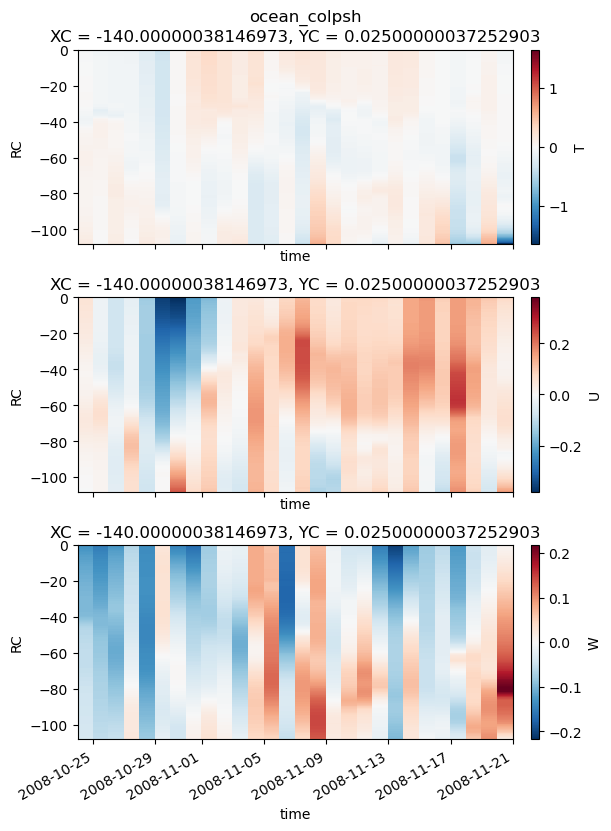

In [17]:
write_to_txt(
    rhs.rename(renamer).compute().sel(time=slice(t0, None)),
    outdir=outdir,
    prefix="ocean_colpsh_",
    interleave=True,
    t0=t0,
)

### initial condition

In [18]:
subds = (
    state[["u", "v", "theta"]]
    .rename({"theta": "temp"})
    .pipe(subsetter)
    .pipe(interpolate, newz)
    .rename(renamer)
)

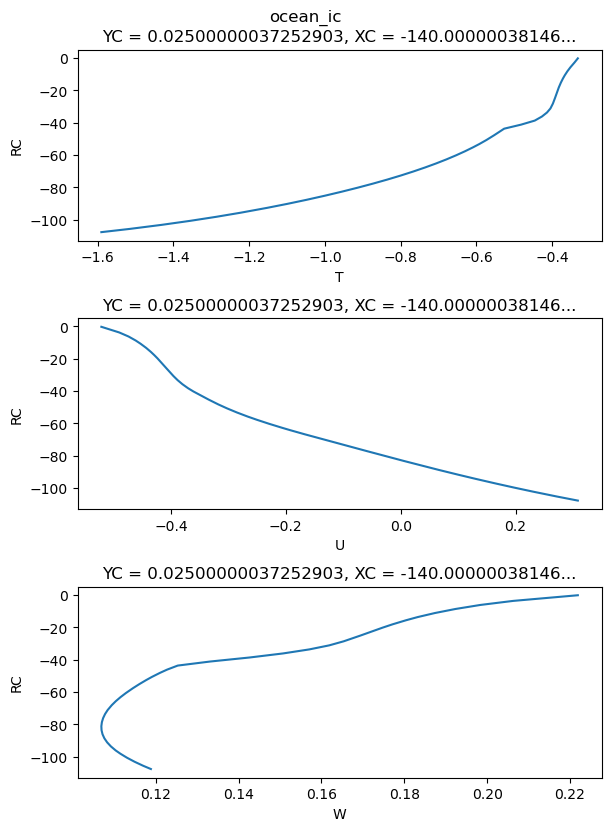

In [19]:
substate = (subds[["U", "W", "T"]].compute()) - offset

ic = substate.cf.interp(time=pd.Timestamp(t0))
write_to_txt(ic.compute(), outdir=outdir, prefix="ocean_ic_", interleave=False)

### restoring

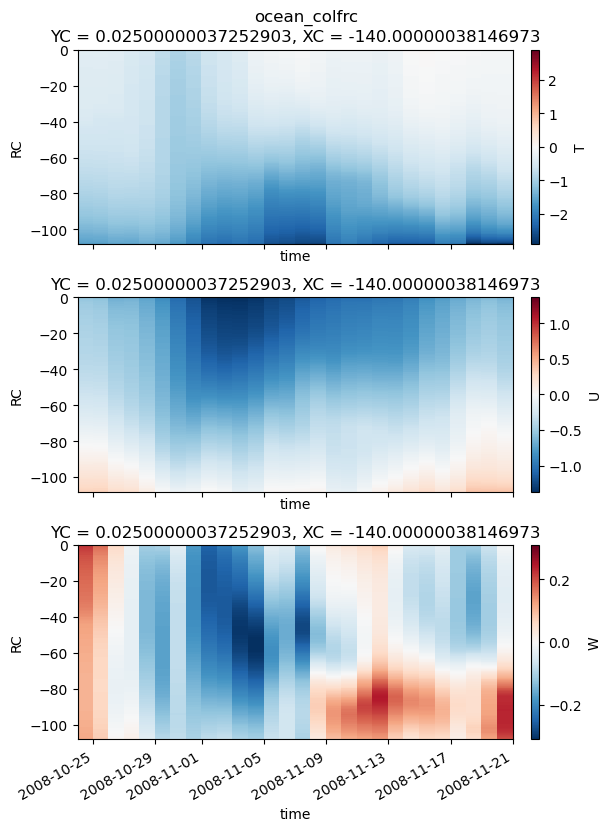

In [20]:
write_to_txt(substate, outdir=outdir, prefix="ocean_colfrc_", interleave=True, t0=t0)

### Estimate surface forcing from JRA using coare3.6

In [21]:
jrafull = pump.obs.read_jra_20()
# undo the local time correction for LES stuff
jrafull["time"] = jrafull.time + pd.Timedelta("7h")

# interpolate to location + subset in time
jrai = (
    jrafull.sel(
        time=slice(
            t0 - pd.Timedelta("2D"),  # something is buggy so start an extra day early
            substate.time[-1] + pd.Timedelta("23H"),
        )
    )
    .interp(latitude=substate.YC.data, longitude=substate.XC.data)
    .compute()
    .interpolate_na("time")
)

In [23]:
if jrai.sizes["time"] == 0:
    raise ValueError("JRA Dataset does not overlap with simulation time period!")

# calculate coare3.6 fluxes
coare, _ = pump.coare_fluxes_jra(
    subsetter(state, time=False).drop(["XG", "YG"]).interp(time=jrai.time.data),
    forcing=jrai,
)
coare.load()
daily_coare = coare.resample(time="D", loffset="12H").mean()

Estimate daily residuals

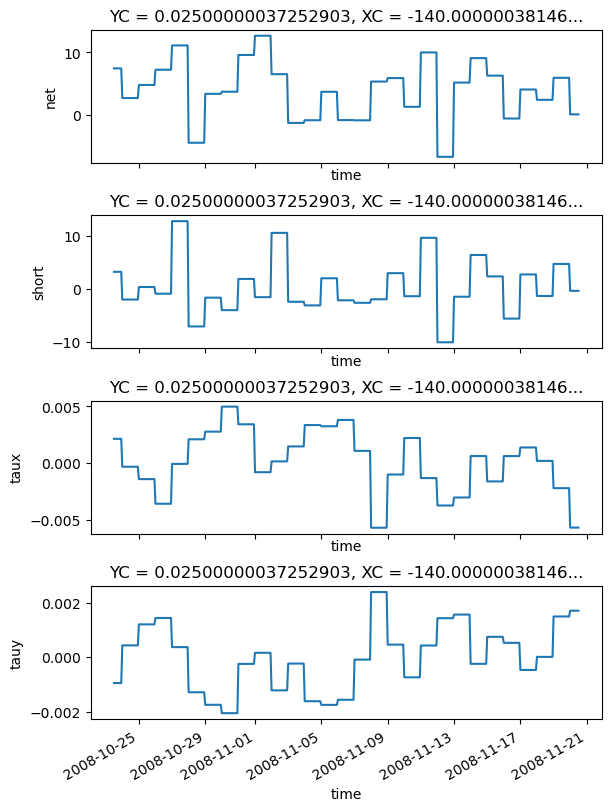

In [24]:
flux_residuals = xr.Dataset()
flux_residuals["short"] = daily_coare.short - surf["oceQsw"].pipe(subsetter, time=False)
flux_residuals["net"] = daily_coare.netflux - surf["TFLUX"].pipe(subsetter, time=False)
flux_residuals["taux"] = daily_coare.taux - surf.taux.pipe(subsetter, time=False)
flux_residuals["tauy"] = daily_coare.tauy - surf.tauy.pipe(subsetter, time=False)
flux_residuals = flux_residuals.reindex(
    time=coare.time.sel(
        time=slice(t0 - pd.Timedelta("1D"), t0 + pd.Timedelta(f"{les_time_length-3}D"))
    ),
    method="nearest",
).load()
for k, v in flux_residuals.isnull().sum().compute().items():
    assert v == 0, "NaNs in flux_residuals"

f = pump.les.debug_plots(flux_residuals)
f.savefig(f"{outdir}/coare_flux_residuals.png", dpi=150)

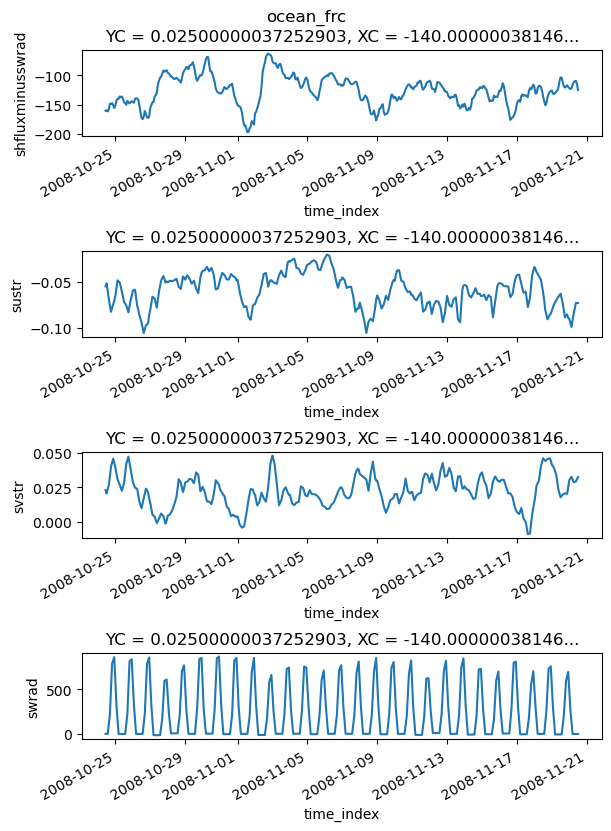

In [25]:
frc = xr.Dataset()
frc["sustr"] = coare.taux - flux_residuals.taux  # ρ * Δz * external forcing term
frc["svstr"] = coare.tauy - flux_residuals.tauy
frc["swrad"] = coare.short - flux_residuals.short
frc["shfluxminusswrad"] = (
    (coare.netflux - coare.short) - (flux_residuals.net - flux_residuals.short)
)

frc = frc.sel(time=slice(t0 - pd.Timedelta("1.5H"), None))
frc = frc.rename({"time": "time_index"})

time = frc.cf.indexes["time_index"].to_numpy()
frc["time"] = ("time_index", (time - t0).astype("timedelta64[s]").astype(float))
frc["time_index"].attrs["axis"] = "T"
frc.load()
write_to_txt(frc, outdir=outdir, prefix="ocean_frc_", interleave=False)

### Test: coare fluxes vs mitgcm

(14176.5, 14206.0)

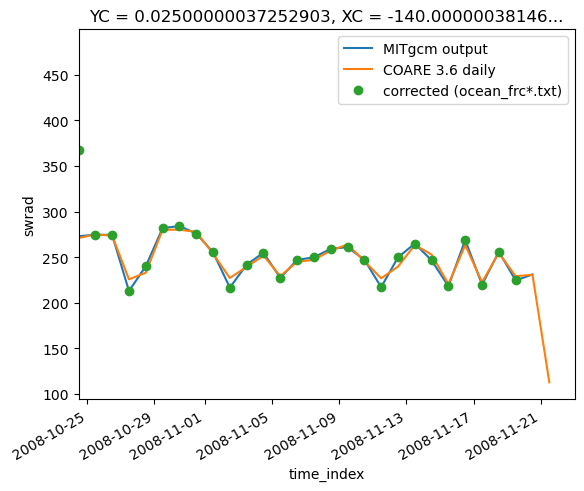

In [26]:
(surf["oceQsw"].pipe(subsetter)).plot()
daily_coare.short.plot()
(frc["swrad"].cf.resample(T="D", loffset="12H").mean()[:-1]).plot(marker='o', ls='none')
plt.legend(["MITgcm output", "COARE 3.6 daily", "corrected (ocean_frc*.txt)"])
plt.xlim((t0, None))

(14176.5, 14206.0)

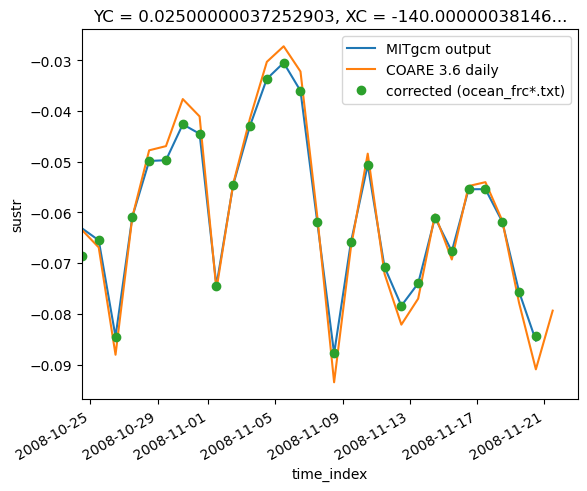

In [27]:
surf.taux.pipe(subsetter).plot()
daily_coare.taux.plot()
frc.cf.resample(T="D", loffset="12H").mean().sustr.plot(marker='o', ls='none')
plt.legend(["MITgcm output", "COARE 3.6 daily", "corrected (ocean_frc*.txt)"])
plt.xlim((t0, None))

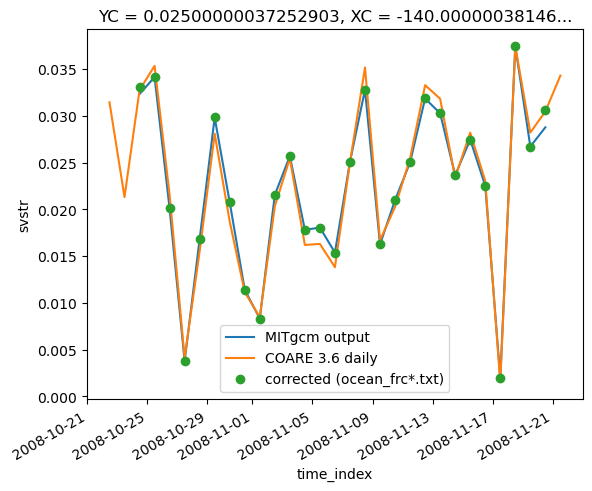

In [28]:
surf.tauy.pipe(subsetter).plot()
daily_coare.tauy.plot()
frc.cf.resample(T="D", loffset="12H").mean().svstr.plot(marker='o', ls='none')
plt.legend(["MITgcm output", "COARE 3.6 daily", "corrected (ocean_frc*.txt)"])

In [ ]:
(surf.TFLUX - surf.oceQsw).pipe(subsetter).plot()
(daily_coare.netflux - daily_coare.short).plot()
frc.shfluxminusswrad.cf.resample(T="D", loffset="12H").mean().plot(marker='o', ls='none')
plt.legend(["MITgcm output", "COARE 3.6 daily", "corrected (ocean_frc*.txt)"])

Raise error here so you don't go past if running every cell :)

In [14]:
stop here

SyntaxError: invalid syntax (<ipython-input-14-a96ba3aab008>, line 1)

---
---

## Debugging checks

### Test: heat budget

/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/dask/array/core.py:377: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


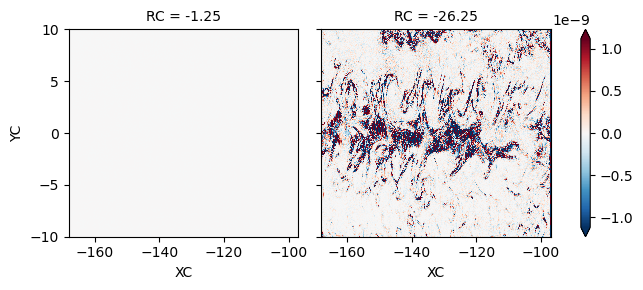

In [103]:
LHS = budgets.TOTTTEND / 86400
RHS = (
    expand_depth(shfluxminusswrad)
    + budgets.surf_corr_tend
    + budgets.MIX_TH
    + budgets.ADV_TH
    + SW
    + budgets.RESIDUAL_TH
)

# t =0 heat budget is weird at the surface
(LHS - RHS).isel(time=1, RC=[0, 10]).plot(robust=True, col="RC")

In [348]:
residual = (LHS - RHS).isel(RC=0)

In [354]:
resmedian = residual.chunk({"time": 1}).median(["XC", "YC"]).compute()

In [353]:
rest = residual.mean(["XC", "YC"]).compute()

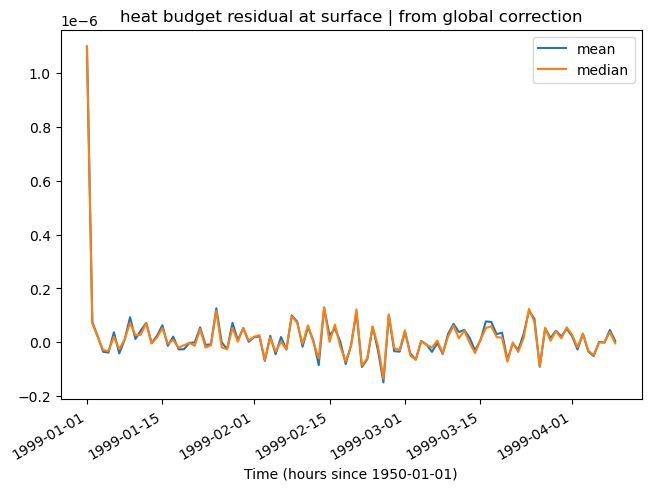

In [363]:
import matplotlib.pyplot as plt

plt.figure(constrained_layout=True)
rest.plot()
resmedian.plot()
plt.legend(["mean", "median"])
plt.title("heat budget residual at surface | from global correction")
plt.savefig("../images/heat-budget-residual.png")

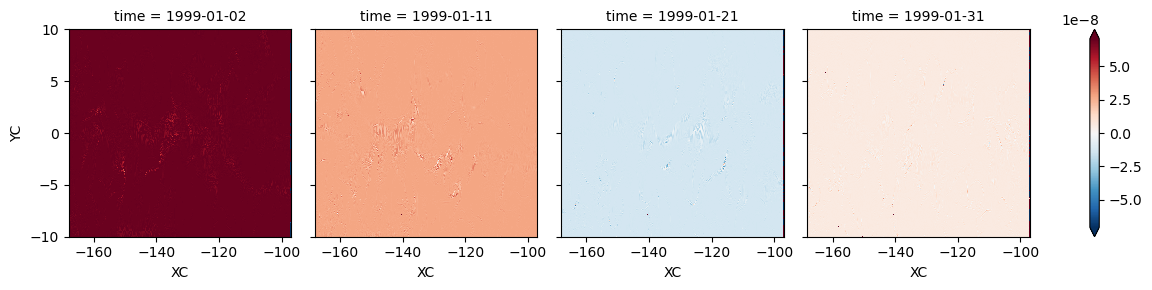

In [352]:
residual.isel(time=[1, 10, 20, 30]).plot(col="time", robust=True)

### Test : U budget

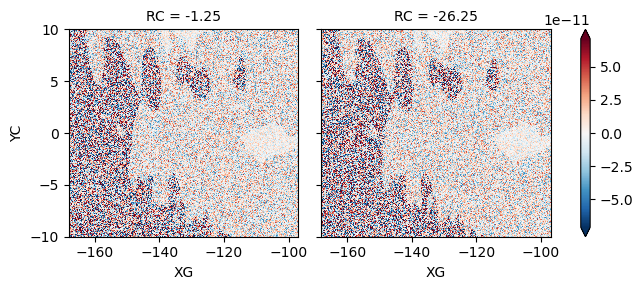

In [291]:
RHS = (
    budgets.SSHx
    + budgets.Um_dPHdx
    + budgets.Um_Advec
    #+ budget.Um_Cori  # is in Um_Advec
    + budgets.Um_Diss
    + budgets.Um_Impl
    + budgets.Um_Ext.fillna(0)
    + budgets.AB_gU
)

LHS = budgets.TOTUTEND / 86400
(LHS - RHS).isel(time=0, RC=[0, 10]).plot(robust=True, col="RC")

### test: V budget

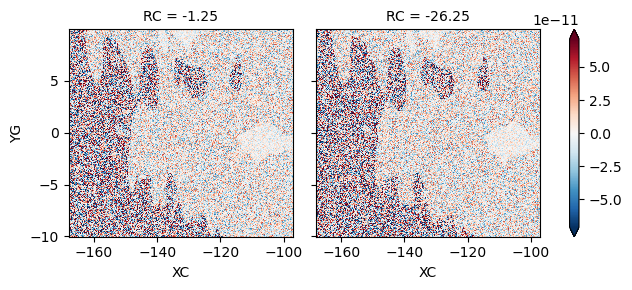

In [290]:
RHS = (
    budgets.SSHy
    + budgets.Vm_dPHdy
    + budgets.Vm_Advec
    #+ budget.Um_Cori  # is in Um_Advec
    + budgets.Vm_Diss
    + budgets.Vm_Impl
    + budgets.Vm_Ext.fillna(0)
    + budgets.AB_gV
)

LHS = budgets.TOTVTEND / 86400
(LHS - RHS).isel(time=0, RC=[0, 10]).plot(robust=True, col="RC")

## ROMS

Todo
/glade/p/cgd/oce/people/dwhitt/TPOS/tpos_LES_runs_setup_scripts/tpos-DIABLO/diablo_2.0/tpos_config_files/ROMS_PSH_6HRLIN_0N140W_108x108x288_5OCT2020_fixedeps/



1. [x] Staggered grid
2. [x] Update grid
2. [x] something is wrong with your ICs (ocean_ic_S.txt and ocean_ic_T.txt and ocean_ic_U.txt). The values are much too small, except for U = -1 + epsilon. U should be m/s (anomaly). S psu (anomaly). T deg C or Kelvin (anomaly). 
3. [x] except ocean_frc_time.txt. Something is off there with the units/order of magnitude. You need to make sure the time that you want the LES to start is zero, so you have to subtract off the initial time and then have all times as seconds after (and before) that point. I think it is necessary to have one time index (i.e. one negative ocean_frc_time value) before the targeted LES start time for interpolation. 
4. [x] please add the time step before each profile as in ocean_colpsh_T.txt in this directory:/glade/p/cgd/oce/people/dwhitt/TPOS/tpos_LES_runs_setup_scripts/tpos-DIABLO/diablo_2.0/tpos_config_files
5. [x] put the outputs in units of deg C per day, m/s per day, psu per day. (I changed the LES to take in units of per day to mitigate precision issues).
6. [x] You need ocean_colfrc_*.txt files, which are for restoring. They are just the basic fields, T(z,t), U(z,t), S(z,t) and V(z,t) (called "W" in LES world; don't ask...).

In [66]:
import xroms

outdir = "/glade/work/dcherian/pump/les_forcing/roms_test/"
dirname = "/glade/p/cgd/oce/people/dwhitt/TPOS/tpos20/OUT/"
files = [
    f"{dirname}/ocean_dia_tpos20_3_d2_2.nc",
    f"{dirname}/ocean_avg_tpos20_3_d2_2.nc",
]

chunk = {"xi": 500, "eta": 120}

ds0 = pump.model.model.read_roms_dataset(files, xi=20, eta=500, ocean_time=50)
rds, grid = xroms.roms_dataset(ds0)
rds["u"] = grid.interp(rds.u, axis="X", boundary="extend")
rds["v"] = grid.interp(rds.v, axis="Y", boundary="extend")
romsds = pump.model.model.make_cartesian(rds)
romsds

/glade/u/home/dcherian/pump/pump/model/model.py:224: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds["ocean_time"] = ds.indexes["ocean_time"].to_datetimeindex()


<xarray.Dataset>
Dimensions:        (boundary: 4, lat_rho: 481, lat_v: 480, lon_rho: 1501, lon_u: 1500, ocean_time: 140, s_rho: 50, s_w: 51, tracer: 2)
Coordinates:
    ntimes         int32 25201
    ndtfast        int32 20
    dt             float64 120.0
    dtfast         float64 6.0
    dstart         object 0027-09-02 00:00:00
    nHIS           int32 3600
    ndefHIS        int32 0
    nRST           int32 3600
    ntsAVG         int32 1
    nAVG           int32 180
    ndefAVG        int32 0
    ntsDIA         int32 1
    nDIA           int32 180
    ndefDIA        int32 0
    nSTA           int32 30
    Falpha         float64 2.0
    Fgamma         float64 0.284
    nl_tnu4        (tracer) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    nl_visc4       float64 1.24e+09
    LuvSponge      int32 0
    LtracerSponge  (tracer) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    Akt_bak        (tracer) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    Akv_bak        float64 1e-05
    rdrg           float64 0.000265
    rdrg2          float64 0.003
    Zob            float64 0.02
    Zos            float64 0.02
    Znudg          float64 0.0
    M2nudg         float64 0.0
    M3nudg         float64 1.0
    Tnudg          (tracer) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    FSobc_in       (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    FSobc_out      (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    M2obc_in       (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    M2obc_out      (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    Tobc_in        (boundary, tracer) float64 dask.array<chunksize=(4, 2), meta=np.ndarray>
    Tobc_out       (boundary, tracer) float64 dask.array<chunksize=(4, 2), meta=np.ndarray>
    M3obc_in       (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    M3obc_out      (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    rho0           float64 1.025e+03
    gamma2         float64 1.0
    LuvSrc         int32 0
    LwSrc          int32 0
    LtracerSrc     (tracer) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    LsshCLM        int32 0
    Lm2CLM         int32 0
    Lm3CLM         int32 0
    LtracerCLM     (tracer) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    LnudgeM2CLM    int32 0
    LnudgeM3CLM    int32 0
    LnudgeTCLM     (tracer) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    Lm2PSH         int32 0
    Lm3PSH         int32 0
    LtracerPSH     (tracer) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    spherical      int32 1
    xl             float64 8.163e+06
    el             float64 2.674e+06
    Vtransform     int32 1
    Vstretching    int32 1
    Tcline         float64 75.0
    hc             float64 75.0
    grid           int32 1
  * s_rho          (s_rho) float64 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
  * s_w            (s_w) float64 -1.0 -0.98 -0.96 -0.94 ... -0.04 -0.02 0.0
    Cs_r           (s_rho) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    Cs_w           (s_w) float64 dask.array<chunksize=(51,), meta=np.ndarray>
    h              (lat_rho, lon_rho) float64 dask.array<chunksize=(481, 20), meta=np.ndarray>
    f              (lat_rho, lon_rho) float64 dask.array<chunksize=(481, 20), meta=np.ndarray>
    pm             (lat_rho, lon_rho) float64 dask.array<chunksize=(481, 20), meta=np.ndarray>
    pn             (lat_rho, lon_rho) float64 dask.array<chunksize=(481, 20), meta=np.ndarray>
  * lon_rho        (lon_rho) float64 -170.0 -170.0 -169.9 ... -95.1 -95.05 -95.0
  * lat_rho        (lat_rho) float64 -12.0 -11.95 -11.9 ... 11.9 11.95 12.0
  * lon_u          (lon_u) float64 -170.0 -169.9 -169.9 ... -95.12 -95.07 -95.02
    lat_u          (lat_rho, lon_u) float64 dask.array<chunksize=(481, 20), meta=np.ndarray>
    lon_v          (lat_v, lon_rho) float64 dask.array<chunksize=(480, 20), meta=np.ndarray>
  * lat_v        

In [67]:
romsds

<xarray.Dataset>
Dimensions:        (boundary: 4, lat_rho: 481, lat_v: 480, lon_rho: 1501, lon_u: 1500, ocean_time: 140, s_rho: 50, s_w: 51, tracer: 2)
Coordinates:
    ntimes         int32 25201
    ndtfast        int32 20
    dt             float64 120.0
    dtfast         float64 6.0
    dstart         object 0027-09-02 00:00:00
    nHIS           int32 3600
    ndefHIS        int32 0
    nRST           int32 3600
    ntsAVG         int32 1
    nAVG           int32 180
    ndefAVG        int32 0
    ntsDIA         int32 1
    nDIA           int32 180
    ndefDIA        int32 0
    nSTA           int32 30
    Falpha         float64 2.0
    Fgamma         float64 0.284
    nl_tnu4        (tracer) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    nl_visc4       float64 1.24e+09
    LuvSponge      int32 0
    LtracerSponge  (tracer) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    Akt_bak        (tracer) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    Akv_bak        float64 1e-05
    rdrg           float64 0.000265
    rdrg2          float64 0.003
    Zob            float64 0.02
    Zos            float64 0.02
    Znudg          float64 0.0
    M2nudg         float64 0.0
    M3nudg         float64 1.0
    Tnudg          (tracer) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    FSobc_in       (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    FSobc_out      (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    M2obc_in       (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    M2obc_out      (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    Tobc_in        (boundary, tracer) float64 dask.array<chunksize=(4, 2), meta=np.ndarray>
    Tobc_out       (boundary, tracer) float64 dask.array<chunksize=(4, 2), meta=np.ndarray>
    M3obc_in       (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    M3obc_out      (boundary) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    rho0           float64 1.025e+03
    gamma2         float64 1.0
    LuvSrc         int32 0
    LwSrc          int32 0
    LtracerSrc     (tracer) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    LsshCLM        int32 0
    Lm2CLM         int32 0
    Lm3CLM         int32 0
    LtracerCLM     (tracer) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    LnudgeM2CLM    int32 0
    LnudgeM3CLM    int32 0
    LnudgeTCLM     (tracer) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    Lm2PSH         int32 0
    Lm3PSH         int32 0
    LtracerPSH     (tracer) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    spherical      int32 1
    xl             float64 8.163e+06
    el             float64 2.674e+06
    Vtransform     int32 1
    Vstretching    int32 1
    Tcline         float64 75.0
    hc             float64 75.0
    grid           int32 1
  * s_rho          (s_rho) float64 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
  * s_w            (s_w) float64 -1.0 -0.98 -0.96 -0.94 ... -0.04 -0.02 0.0
    Cs_r           (s_rho) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    Cs_w           (s_w) float64 dask.array<chunksize=(51,), meta=np.ndarray>
    h              (lat_rho, lon_rho) float64 dask.array<chunksize=(481, 20), meta=np.ndarray>
    f              (lat_rho, lon_rho) float64 dask.array<chunksize=(481, 20), meta=np.ndarray>
    pm             (lat_rho, lon_rho) float64 dask.array<chunksize=(481, 20), meta=np.ndarray>
    pn             (lat_rho, lon_rho) float64 dask.array<chunksize=(481, 20), meta=np.ndarray>
  * lon_rho        (lon_rho) float64 -170.0 -170.0 -169.9 ... -95.1 -95.05 -95.0
  * lat_rho        (lat_rho) float64 -12.0 -11.95 -11.9 ... 11.9 11.95 12.0
  * lon_u          (lon_u) float64 -170.0 -169.9 -169.9 ... -95.12 -95.07 -95.02
    lat_u          (lat_rho, lon_u) float64 dask.array<chunksize=(481, 20), meta=np.ndarray>
    lon_v          (lat_v, lon_rho) float64 dask.array<chunksize=(480, 20), meta=np.ndarray>
  * lat_v        

In [19]:
t0 = subsetter(ds).ocean_time[1].data  # pd.Timestamp("1985-Oct-02 00:00:00").to_numpy()
subds = ds.pipe(subsetter).pipe(interpolate, newz).rename(renamer)

### RHS forcing

In [20]:
rhs = xr.Dataset()

rhs_tracer = ["hadv", "vadv", "hdiff"]
rhs_mom = ["prsgrd", "hadv", "vadv", "hvisc"]
    
for var, terms in zip(
    ["u", "v", "temp", "salt"], [rhs_mom, rhs_mom, rhs_tracer, rhs_tracer]
):
    varnames = [f"{var}_{term}" for term in terms]
    rhs[var] = (subds[varnames].to_array("term").sum("term")) * 86400
    rhs[var].attrs["description"] = f"sum over {varnames}"
rhs

<xarray.Dataset>
Dimensions:      (ocean_time: 20, z_rho: 216)
Coordinates:
    nDIA         int32 180
    LwSrc        int32 0
    Zos          float64 0.02
    Fgamma       float64 0.284
    lon_u        float64 -140.0
    Zob          float64 0.02
    ntsDIA       int32 1
    rdrg         float64 0.000265
    mask_rho     float64 1.0
    z_rho_psi    (ocean_time, z_rho) float64 -107.8 -107.3 ... -0.7773 -0.2768
    gamma2       float64 1.0
    f            float64 4.514e-18
    ndefAVG      int32 0
    dt           float64 120.0
    z_rho_v      (ocean_time, z_rho) float64 -107.7 -107.2 ... -0.776 -0.2764
    ntimes       int32 25201
    lon_rho      float64 -140.0
    ndtfast      int32 20
    mask_u       float64 1.0
    lon_v        float64 -140.0
    Falpha       float64 2.0
    M2nudg       float64 0.0
  * z_rho        (z_rho) float64 -107.8 -107.2 -106.8 ... -1.25 -0.75 -0.25
    LuvSrc       int32 0
    dstart       object 0027-09-02 00:00:00
    ntsAVG       int32 1
    xl           float64 8.163e+06
    Vtransform   int32 1
    dtfast       float64 6.0
    Lm2PSH       int32 0
    pn           float64 0.0001799
    LsshCLM      int32 0
    LnudgeM2CLM  int32 0
    mask_v       float64 1.0
    rdrg2        float64 0.003
    z_rho0       (z_rho) float64 -108.1 -107.6 -107.1 ... -1.577 -1.077 -0.5769
    lat_u        float64 1.772e-12
    LnudgeM3CLM  int32 0
    Cs_r         (z_rho) float64 -0.02114 -0.02104 ... -0.0002008 -0.0001072
    rho0         float64 1.025e+03
    hc           float64 75.0
    nHIS         int32 3600
    ndefDIA      int32 0
    el           float64 2.674e+06
    angle        float64 4.106e-14
    pm           float64 0.0001799
    Znudg        float64 0.0
    spherical    int32 1
    ndefHIS      int32 0
    Akv_bak      float64 1e-05
    z_rho_v0     (z_rho) float64 -108.0 -107.5 -107.0 ... -1.576 -1.076 -0.5765
    nl_visc4     float64 1.24e+09
    grid         int32 1
    z_rho_u0     (z_rho) float64 -108.2 -107.7 -107.2 ... -1.578 -1.078 -0.5774
    nSTA         int32 30
    M3nudg       float64 1.0
    nRST         int32 3600
    Tcline       float64 75.0
    Lm2CLM       int32 0
    Lm3PSH       int32 0
    mask_psi     float64 1.0
    Lm3CLM       int32 0
    lat_psi      float64 -0.025
    s_rho        (z_rho) float64 -0.2463 -0.2455 -0.2446 ... -0.003013 -0.001633
    z_rho_u      (ocean_time, z_rho) float64 -107.8 -107.3 ... -0.777 -0.2766
  * ocean_time   (ocean_time) datetime64[ns] 1985-10-02T03:00:00 ... 1985-10-...
    lat_rho      float64 1.45e-14
    LuvSponge    int32 0
    nAVG         int32 180
    lat_v        float64 -0.025
    h            float64 4.314e+03
    z_rho_psi0   (z_rho) float64 -108.2 -107.7 -107.2 ... -1.578 -1.078 -0.5774
    lon_psi      float64 -140.0
    Vstretching  int32 1
Data variables:
    u            (ocean_time, z_rho) float64 0.0935 0.09244 ... 0.1627 0.1625
    v            (ocean_time, z_rho) float64 0.106 0.1083 ... -0.0536 -0.05361
    temp         (ocean_time, z_rho) float64 -0.8086 -0.7765 ... -0.02899
    salt         (ocean_time, z_rho) float64 -0.02245 -0.02013 ... 0.0006571

In [21]:
write_to_txt(
    rhs.rename(renamer).pipe(interleave_time, t0),
    outdir=outdir,
    prefix="ocean_colpsh_",
)

### initial condition

In [22]:
substate = (subds[["U", "W", "T", "S"]].compute()) - offset

ic = substate.cf.sel(time=t0)
write_to_txt(ic.compute(), outdir=outdir, prefix="ocean_ic_")

### restoring

In [23]:
write_to_txt(interleave_time(substate, t0), outdir=outdir, prefix="ocean_colfrc_")

### surface forcing

In [24]:
frc = subds[["sustr", "svstr", "swrad", "ssflux"]]
frc["shfluxminusswrad"] = subds["shflux"] - frc["swrad"]

time = subds.indexes["ocean_time"].to_numpy()
frc["time"] = ("ocean_time", (time - t0).astype("timedelta64[s]").astype(float))
frc.load()

write_to_txt(frc, outdir=outdir, prefix="ocean_frc_")

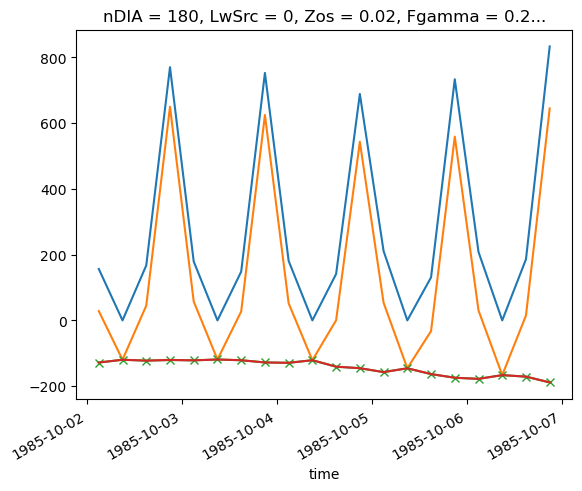

In [25]:
# Test flux calculations
shflux2 = subds[["lwrad", "latent", "sensible"]].to_array().sum("variable")

subds.swrad.plot()
subds.shflux.plot()
(-subds.swrad + subds.shflux).plot(marker='x')
(shflux2).plot()